<a href="https://colab.research.google.com/github/GeoTurkey/GMT_COURSES/blob/main/network_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network analysis in Python

Finding a shortest path using a specific street network is a common GIS problem that has many practical
applications. For example navigators are one of those "every-day" applications where **routing** using specific algorithms is used to find the optimal route between two (or multiple) points.

It is also possible to perform network analysis such as tranposrtation routing in Python.
[Networkx](https://networkx.github.io/documentation/stable/) is a Python module that provides tools for analyzing networks in various different ways. It also contains algorithms
such as [Dijkstra's algorithm](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.weighted.single_source_dijkstra.html#networkx.algorithms.shortest_paths.weighted.single_source_dijkstra) or
[A*](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.astar.astar_path.html#networkx.algorithms.shortest_paths.astar.astar_path) algoritm that are commonly used to find shortest paths along transportation network.

To be able to conduct network analysis, it is, of course, necessary to have a network that is used for the analyses. The [OSMnx](https://github.com/gboeing/osmnx) package enables us to retrieve routable networks from OpenStreetMap for various transport modes (walking, cycling and driving). OSMnx also combines some functionalities from `networkx` module to make it straightforward to conduct routing analysis based on OpenStreetMap data.

Next we will test the routing functionalities of OSMnx by finding a shortest path between two points based on drivable roads. With tiny modifications, it is also possible to repeat the analysis for the walkable street network.

## Get the network

Let's again start by importing the required modules

In [1]:
! pip install contextily

  Obtaining dependency information for contextily from https://files.pythonhosted.org/packages/d2/84/dbcd682289fe8fa3f7c16318e06a7626608f767a9a163954df58f245adef/contextily-1.6.0-py3-none-any.whl.metadata
  Obtaining dependency information for geopy from https://files.pythonhosted.org/packages/e5/15/cf2a69ade4b194aa524ac75112d5caac37414b20a3a03e6865dfe0bd1539/geopy-2.4.1-py3-none-any.whl.metadata
  Using cached geopy-2.4.1-py3-none-any.whl.metadata (6.8 kB)
  Obtaining dependency information for mercantile from https://files.pythonhosted.org/packages/b2/d6/de0cc74f8d36976aeca0dd2e9cbf711882ff8e177495115fd82459afdc4d/mercantile-1.2.1-py3-none-any.whl.metadata
  Obtaining dependency information for rasterio from https://files.pythonhosted.org/packages/03/d9/40d44154946a55e8fe63b21d44120dae02f4f62500338d09ee0d29d59025/rasterio-1.3.10-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for joblib from https://files.pythonhosted.org/packages/91/29/df4b9b42f2be0b623cbd5e214


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from pyproj import CRS
import contextily as ctx
import warnings
warnings.filterwarnings('ignore')

When fetching network data from OpenStreetMap using OSMnx, it is possible to define the type of street network using the `network_type` parameter (see options from the [OSMnx documentation](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=graph%20from%20place#osmnx.graph.graph_from_place)).
Let's download the OSM data from "Üniversiteler Mahallesi" and drivable roads.

In [2]:
place_name = "Üniversiteler Mahallesi, Çankaya, Ankara"
# Retrieve the network
graph = ox.graph_from_place(place_name, network_type='drive')

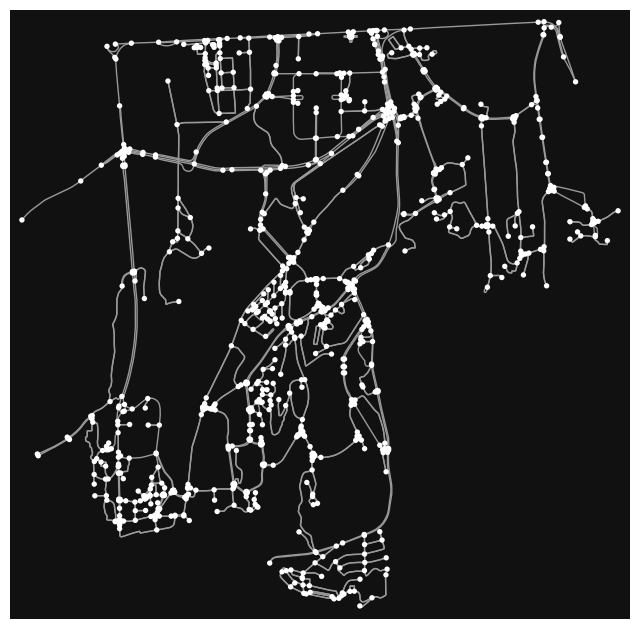

In [3]:
# plot the graph:
fig, ax = ox.plot_graph(graph)

Pro tip! Sometimes the shortest path might go slightly outside the defined area of interest. To account for this, we can fetch the network for a bit larger area than the district of Universiteler Mahallesi, in case the shortest path is not completely inside its boundaries.

In [4]:
# Get the area of interest polygon
place_polygon = ox.geocode_to_gdf(place_name)

# Re-project the polygon to a local projected CRS
place_polygon = place_polygon.to_crs(epsg=32636)

# Buffer a bit
place_polygon["geometry"] = place_polygon.buffer(1000)

# Re-project the polygon back to WGS84, as required by osmnx
place_polygon = place_polygon.to_crs(epsg=4326)


In [5]:
place_polygon

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((32.70618 39.87860, 32.70536 39.87958...",39.908662,39.842042,32.812111,32.715164,217135249,relation,6789069,39.875049,32.7664,boundary,administrative,16,0.35001,city_district,Üniversiteler Mahallesi,"Üniversiteler Mahallesi, Çankaya, Ankara, Cent..."


In [6]:
# Retrieve the network
graph = ox.graph_from_polygon(place_polygon["geometry"].values[0], network_type='drive')

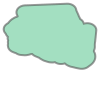

In [7]:
place_polygon["geometry"].values[0]

Plot the graph:

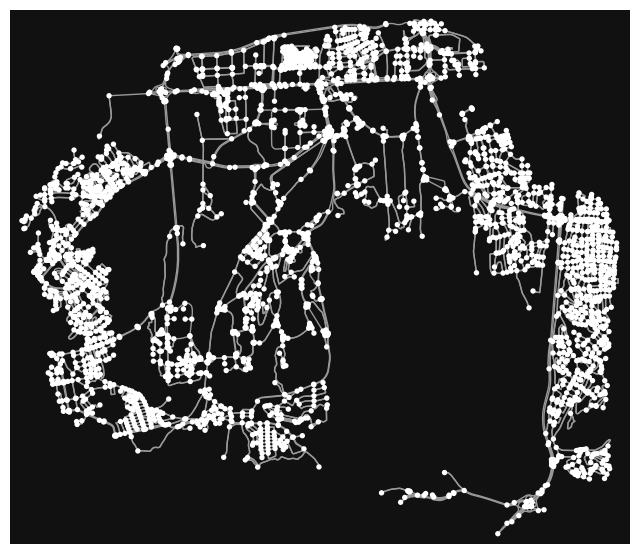

In [8]:
fig, ax = ox.plot_graph(graph)

Okey so now we have streets for the travel mode we specified earlier. Let's have a colser look at the attributes of the street network. Easiest way to do this is to convert the
graph (nodes and edges) into GeoDataFrames.

Converting graph into a GeoDataFrame can be done with function `graph_to_gdfs()` that we already used in previous tutorial. With parameters `nodes` and `edges`, it is possible to control whether to retrieve both nodes and edges from the graph.

In [9]:
# Retrieve only edges from the graph
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)

In [10]:
# Check columns
edges.columns

Index(['osmid', 'oneway', 'lanes', 'ref', 'name', 'highway', 'maxspeed',
       'reversed', 'length', 'bridge', 'geometry', 'junction', 'access',
       'tunnel', 'width'],
      dtype='object')

In [11]:
# Check crs
edges.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Note that the CRS of the GeoDataFrame is be WGS84 (epsg: 4326).

In [12]:
edges.head()

,,,osmid,oneway,lanes,ref,name,highway,maxspeed,reversed,length,bridge,geometry,junction,access,tunnel,width
u,v,key,,,,,,,,,,,,,,,
27046640,11033172719,0,1158312502,True,5,D200,Dumlupınar Blv.,trunk,82,False,197.586,NaN,"LINESTRING (32.78412 39.90866, 32.78180 39.90859)",NaN,NaN,NaN,NaN
27046645,393950525,0,"[1073556155, 1073556156, 34344989]",True,5,NaN,Dumlupınar Blv.,trunk,82,False,74.870,yes,"LINESTRING (32.78652 39.90877, 32.78634 39.908...",NaN,NaN,NaN,NaN
27046662,61770431,0,1071657277,True,4,D200,Dumlupınar Blv.,trunk,82,False,295.668,NaN,"LINESTRING (32.73864 39.90687, 32.73518 39.90673)",NaN,NaN,NaN,NaN
29284954,29284955,0,279822521,True,3,NaN,Anadolu Bulvarı,primary,50,False,107.942,NaN,"LINESTRING (32.78206 39.91714, 32.78312 39.91661)",NaN,NaN,NaN,NaN
29284955,10845943810,0,279822521,True,3,NaN,Anadolu Bulvarı,primary,50,False,58.223,NaN,"LINESTRING (32.78312 39.91661, 32.78367 39.91631)",NaN,NaN,NaN,NaN


Okey, so we have quite many columns in our GeoDataFrame. Most of the columns are fairly self-explanatory but the following table describes all of them.
Most of the attributes come directly from the OpenStreetMap, however, columns `u` and `v` are Networkx specific ids. You can click on the links to get more information about each attribute:


| Column                                                     | Description                 | Data type         |
|------------------------------------------------------------|-----------------------------|-------------------|
| [bridge](http://wiki.openstreetmap.org/wiki/Key:bridge)    | Bridge feature              | boolean           |
| geometry                                                   | Geometry of the feature     | Shapely.geometry  |
| [highway](http://wiki.openstreetmap.org/wiki/Key:highway)  | Tag for roads (road type)   | str / list        |
| [lanes](http://wiki.openstreetmap.org/wiki/Key:lanes)      | Number of lanes             | int (or nan)      |
| [lenght](http://wiki.openstreetmap.org/wiki/Key:length)    | Length of feature (meters)  | float             |
| [maxspeed](http://wiki.openstreetmap.org/wiki/Key:maxspeed)| maximum legal speed limit   | int /list         |
| [name](http://wiki.openstreetmap.org/wiki/Key:name)        | Name of the (street) element| str (or nan)      |
| [oneway](http://wiki.openstreetmap.org/wiki/Key:oneway)    | One way road                | boolean           |
| [osmid](http://wiki.openstreetmap.org/wiki/Node)           | Unique ids for the element  | list              |
| [u](http://ow.ly/bV8n30h7Ufm)                              | The first node of edge      | int               |
| [v](http://ow.ly/bV8n30h7Ufm)                              | The last node of edge       | int               |


Let's take a look what kind of features we have in the `highway` column:

In [13]:
edges['highway'].value_counts()

highway
residential                          5808
tertiary                              790
secondary                             561
primary                               365
trunk                                 116
unclassified                          109
primary_link                           63
trunk_link                             39
secondary_link                         24
tertiary_link                          23
[secondary, tertiary]                   4
[unclassified, residential]             4
[tertiary, residential]                 2
[secondary, primary]                    2
[secondary, residential, primary]       2
[living_street, residential]            2
[tertiary, primary]                     2
road                                    2
[secondary, primary_link]               1
[secondary_link, primary_link]          1
[primary_link, primary]                 1
[secondary_link, primary]               1
[trunk_link, trunk]                     1
Name: count, dtype: int64

I now we can confirm that as a result our street network indeed only contains such streets where it is allowed to drive with a car as there are no e.g. cycleways or footways included in the data.

As the data is in WGS84 format, we might want to reproject our data into a metric system before proceeding to the shortest path analysis.
We can re-project the graph from latitudes and longitudes to an appropriate UTM zone using the [project_graph()](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.projection.project_graph) function from OSMnx.

In [14]:
# Project the data
graph_proj = ox.project_graph(graph)

In [15]:
# Get Edges and Nodes
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

In [16]:
print("Coordinate system:", edges_proj.crs)
print("Coordinate system:", nodes_proj.crs)

Coordinate system: EPSG:32636
Coordinate system: EPSG:32636


In [17]:
nodes_proj.head()

,y,x,street_count,lon,lat,highway,geometry
osmid,,,,,,,
27046640,4.417642e+06,481547.703853,3,32.784116,39.908662,NaN,POINT (481547.704 4417642.033)
11033172719,4.417634e+06,481349.855476,3,32.781802,39.908588,NaN,POINT (481349.855 4417634.278)
27046645,4.417654e+06,481753.314259,3,32.786522,39.908774,NaN,POINT (481753.314 4417653.969)
393950525,4.417650e+06,481678.403786,3,32.785645,39.908736,NaN,POINT (481678.404 4417649.887)
27046662,4.417453e+06,477660.164643,3,32.738641,39.906869,NaN,POINT (477660.165 4417453.349)


Okey, as we can see from the CRS the data is now in [UTM projection](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system) using zone 36 which is the one used for TURKEY, and indeed the orientation of the map and the geometry values also confirm this.


Furthermore, we can check the epsg code of this projection using pyproj CRS:

In [18]:
CRS(edges_proj.crs).to_epsg()

32636

Indeed, the projection is now [WGS 84 / UTM zone 36N, EPSG:32636](https://epsg.io/32636).

## Shortest path analysis

Let's now calculate the shortest path between two points using the [shortest path function in Networkx](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.generic.shortest_path.html#shortest-path).

#### Origin and destination points

First we need to specify the source and target locations for our route. If you are familiar with the Universiteler MAhallesi area, you can specify a custom placename as a source location. Or, you can follow along and choose these points as the origin and destination in the analysis:
- [Beytepe Gün Hastanesi](https://nominatim.openstreetmap.org/ui/search.html?q=Beytepe+G%C3%BCn) - hospital area and current startup hub.
- [Yükseköğretim Kurulu](https://nominatim.openstreetmap.org/ui/search.html?q=Y%C3%BCksek%C3%B6%C4%9Fretim+Kurulu) - YÖK building in Bilkent.

We could figure out the coordinates for these locations manually, and create shapely points based on the coordinates.
However,  it is more handy to fetch the location of our source destination directly from OSM:

In [19]:
# Set place name
placename = "Beytepe Gün Hastanesi"

In [20]:
# Geocode the place name
geocoded_place = ox.geocode_to_gdf(placename)

In [21]:
# Check the result
geocoded_place

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((32.73336 39.86792, 32.73337 39.86785...",39.868142,39.867543,32.733933,32.733361,216474944,way,544163794,39.867832,32.733637,building,hospital,30,0.00001,building,Beytepe Gün Hastanesi,"Beytepe Gün Hastanesi, 1596. Cd., Üniversitele..."


In [22]:
geocoded_place.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

As output, we received the building footprint. From here, we can get the centroid as the source location of our shortest path analysis. However, we first need to project the data into the correct crs:

In [23]:
# Re-project into the same CRS as the road network
geocoded_place = geocoded_place.to_crs(CRS(edges_proj.crs))

In [24]:
geocoded_place.crs

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [25]:
geocoded_place

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((477195.942 4413131.390, 477196.800 4...",39.868142,39.867543,32.733933,32.733361,216474944,way,544163794,39.867832,32.733637,building,hospital,30,0.00001,building,Beytepe Gün Hastanesi,"Beytepe Gün Hastanesi, 1596. Cd., Üniversitele..."


In [26]:
# Get centroid as shapely point
origin = geocoded_place["geometry"].centroid.values[0]

In [27]:
print(origin)

POINT (477220.3000015202 4413124.292571072)


Great! Now we have defined the origin point for our network analysis.
We can repeat the same steps to retrieve central point of *ruttopuisto*-park as the destination:

In [28]:
# Set place name
placename = "Yükseköğretim Kurulu"

# Geocode the place name
geocoded_place = ox.geocode_to_gdf(placename)

# Re-project into the same CRS as the road network
geocoded_place = geocoded_place.to_crs(CRS(edges_proj.crs))

# Get centroid of the polygon as shapely point
destination = geocoded_place["geometry"].centroid.values[0]

print(destination)

POINT (479601.6050168251 4414131.373820656)


Now we have shapely points representing the origin and destination locations for our network analysis. Next step is to find these points on the routable network before the final routing.

#### Nearest node

Let's now find the nearest graph nodes (and their node IDs) to these points using OSMnx [distance.nearest_nodes](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.nearest_nodes).
As a starting point, we have the two Shapely Point objects we just defined as the origin and destination locations.

Find the nearest node to a point or to each of several points.

If X and Y are single coordinate values, this will return the nearest node to that point. If X and Y are lists of coordinate values, this will return the nearest node to each point.

If the graph is projected, this uses a k-d tree for euclidean nearest neighbor search, which requires that scipy is installed as an optional dependency. If it is unprojected, this uses a ball tree for haversine nearest neighbor search, which requires that scikit-learn is installed as an optional dependency.

In [29]:
! pip install scipy


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
# Find the node in the graph that is closest to the origin point (here, we want to get the node id)
orig_node_id = ox.distance.nearest_nodes(graph_proj, origin.x, origin.y)
orig_node_id

2190683018

In [31]:
# Find the node in the graph that is closest to the target point (here, we want to get the node id)
target_node_id = ox.distance.nearest_nodes(graph_proj, destination.x, destination.y)
target_node_id

1830393332

Now we have the IDs for the closest nodes that were found from the graph to the origin and target points that we specified.

Let's retrieve the node information from the `nodes_proj` GeoDataFrame by passing the ids to the `loc` indexer

In [32]:
nodes_proj.head()

,y,x,street_count,lon,lat,highway,geometry
osmid,,,,,,,
27046640,4.417642e+06,481547.703853,3,32.784116,39.908662,NaN,POINT (481547.704 4417642.033)
11033172719,4.417634e+06,481349.855476,3,32.781802,39.908588,NaN,POINT (481349.855 4417634.278)
27046645,4.417654e+06,481753.314259,3,32.786522,39.908774,NaN,POINT (481753.314 4417653.969)
393950525,4.417650e+06,481678.403786,3,32.785645,39.908736,NaN,POINT (481678.404 4417649.887)
27046662,4.417453e+06,477660.164643,3,32.738641,39.906869,NaN,POINT (477660.165 4417453.349)


In [33]:
# Retrieve the rows from the nodes GeoDataFrame based on the node id (node id is the index label)
orig_node = nodes_proj.loc[orig_node_id]
target_node = nodes_proj.loc[target_node_id]

In [34]:
orig_node

y                                             4413120.638253
x                                              477183.868024
street_count                                               3
lon                                                 32.73322
lat                                                39.867819
highway                                                  NaN
geometry        POINT (477183.86802443804 4413120.638252617)
Name: 2190683018, dtype: object

In [35]:
target_node

y                                            4414108.623696
x                                             479504.258394
street_count                                              3
lon                                                32.76032
lat                                                39.87678
highway                                                 NaN
geometry        POINT (479504.2583941403 4414108.623696389)
Name: 1830393332, dtype: object

Let's also create a GeoDataFrame that contains these points

In [36]:
# Create a GeoDataFrame from the origin and target points
od_nodes = gpd.GeoDataFrame([orig_node, target_node], geometry='geometry', crs=nodes_proj.crs)
od_nodes.head()

,y,x,street_count,lon,lat,highway,geometry
2190683018,4.413121e+06,477183.868024,3,32.73322,39.867819,NaN,POINT (477183.868 4413120.638)
1830393332,4.414109e+06,479504.258394,3,32.76032,39.876780,NaN,POINT (479504.258 4414108.624)


Okay, as a result we got now the closest node IDs of our origin and target locations. As you can see, the `index` in this GeoDataFrame corresponds to the IDs that we found with `distance.nearest_nodes()` function.

#### Routing

Now we are ready to do the routing and find the shortest path between the origin and target locations
by using the `shortest_path()` [function](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.generic.shortest_path.html) of networkx.
With `weight` -parameter we can specify that `'length'` attribute should be used as the cost impedance in the routing. If specifying the weight parameter, NetworkX will use by default Dijkstra's algorithm to find the optimal route. We need to specify the graph that is used for routing, and the origin `ID` (*source*) and the target `ID` in between the shortest path will be calculated:


In [37]:
# Calculate the shortest path
route = nx.shortest_path(G=graph_proj, source=orig_node_id, target=target_node_id, weight='length')

# Show what we have
print(route)

[2190683018, 8533662516, 8533662515, 8533672124, 8533672128, 8533662483, 2190728551, 2349163258, 2190728553, 2190728556, 2190728559, 2190672584, 6694304244, 2190672587, 2190728539, 2345117633, 8533672289, 2190728535, 2190728565, 8533672168, 11238075878, 11259631015, 8533672177, 8533672159, 1312329482, 9032600778, 9032600793, 9028350330, 9028350333, 9028350357, 9028350336, 9028433976, 9028433974, 9028433972, 206189569, 206189548, 206189546, 310043096, 1043879537, 206189540, 288238726, 288204402, 2144951652, 2342970965, 2190697077, 2190697095, 2359839297, 493134885, 680392150, 148985787, 2190697113, 2190697085, 7918183291, 2359839294, 1830392905, 1830393332]


As a result we get a list of all the nodes that are along the shortest path.

- We could extract the locations of those nodes from the `nodes_proj` GeoDataFrame and create a LineString presentation of the points, but luckily, OSMnx can do that for us and we can plot shortest path by using `plot_graph_route()` function:


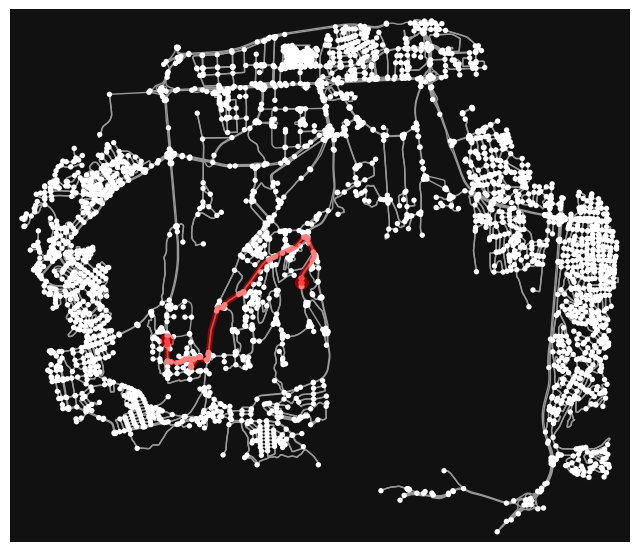

In [38]:
# Plot the shortest path
fig, ax = ox.plot_graph_route(graph_proj, route)

Nice! Now we have the shortest path between our origin and target locations.
Being able to analyze shortest paths between locations can be valuable information for many applications.
Here, we only analyzed the shortest paths based on distance but quite often it is more useful to find the
optimal routes between locations based on the travelled time. Here, for example we could calculate the time that it takes to cross each road segment by dividing the length of the road segment with the speed limit and calculate the optimal routes by taking into account the speed limits as well that might alter the result especially on longer trips than here.

## Saving shortest paths to disk

Quite often you need to save the route into a file for further analysis and visualization purposes, or at least have it as a GeoDataFrame object in Python.
Hence, let's continue still a bit and see how we can turn the route into a linestring and save the shortest path geometry and related attributes into a geopackage file.

- First we need to get the nodes that belong to the shortest path:


In [39]:
# Get the nodes along the shortest path
route_nodes = nodes_proj.loc[route]
route_nodes

,y,x,street_count,lon,lat,highway,geometry
osmid,,,,,,,
2190683018,4.413121e+06,477183.868024,3,32.733220,39.867819,NaN,POINT (477183.868 4413120.638)
8533662516,4.413097e+06,477180.333756,4,32.733179,39.867606,NaN,POINT (477180.334 4413097.019)
8533662515,4.413028e+06,477182.120317,3,32.733203,39.866984,NaN,POINT (477182.120 4413027.946)
8533672124,4.412763e+06,477184.997563,3,32.733246,39.864593,NaN,POINT (477184.998 4412762.618)
8533672128,4.412749e+06,477184.640005,3,32.733242,39.864469,NaN,POINT (477184.640 4412748.845)
8533662483,4.412746e+06,477201.122099,4,32.733435,39.864446,NaN,POINT (477201.122 4412746.188)
2190728551,4.412746e+06,477257.561508,3,32.734095,39.864443,NaN,POINT (477257.562 4412745.754)
2349163258,4.412733e+06,477351.562881,3,32.735194,39.864330,NaN,POINT (477351.563 4412732.944)
2190728553,4.412745e+06,477407.192193,3,32.735844,39.864439,NaN,POINT (477407.192 4412744.877)


As we can see, now we have all the nodes that were part of the shortest path as a GeoDataFrame.

- Now we can create a LineString out of the Point geometries of the nodes:

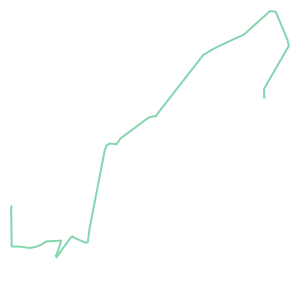

In [40]:
from shapely.geometry import LineString, Point

# Create a geometry for the shortest path
route_line = LineString(list(route_nodes["geometry"].values))
route_line

In [41]:
print(route_line)

LINESTRING (477183.86802443804 4413120.638252617, 477180.33375562745 4413097.01926866, 477182.1203168183 4413027.945557703, 477184.99756326096 4412762.618130222, 477184.6400046101 4412748.845484297, 477201.1220994352 4412746.188077737, 477257.56150786934 4412745.753604187, 477351.5628810564 4412732.943917446, 477407.1921926992 4412744.877101144, 477455.3365346474 4412762.27120813, 477470.8538396971 4412774.6784081105, 477507.0645215375 4412794.272297118, 477636.3160808827 4412800.374858302, 477637.45874442405 4412799.206133592, 477595.21936358645 4412668.9512882065, 477588.4396838162 4412664.087653326, 477594.49118573696 4412651.0398356505, 477605.29468340345 4412663.072661326, 477721.0504825025 4412824.300815056, 477740.51924965344 4412839.860225534, 477749.7884532691 4412830.343701949, 477861.2402284986 4412780.1417926485, 477880.00060851005 4412787.412747235, 477881.79910077975 4412797.107961169, 477891.57965569233 4412872.651920308, 477892.51376266946 4412879.208655361, 477896.7719

Now we have the route as a LineString geometry.

- Let's make a GeoDataFrame out of it having some useful information about our route such as a list of the osmids that are part of the route and the length of the route.

In [42]:
# Create a GeoDataFrame
route_geom = gpd.GeoDataFrame([[route_line]], geometry='geometry', crs=edges_proj.crs, columns=['geometry'])
route_geom

,geometry
0,"LINESTRING (477183.868 4413120.638, 477180.334..."


In [43]:
# Add a list of osmids associated with the route
route_geom.loc[0, 'osmids'] = str(list(route_nodes.index.values))
route_geom

,geometry,osmids
0,"LINESTRING (477183.868 4413120.638, 477180.334...","[2190683018, 8533662516, 8533662515, 853367212..."


In [44]:

# Calculate the route length
route_geom['length_m'] = route_geom.length
route_geom

,geometry,osmids,length_m
0,"LINESTRING (477183.868 4413120.638, 477180.334...","[2190683018, 8533662516, 8533662515, 853367212...",5220.271674


Now we have a GeoDataFrame that we can save to disk. Let's still confirm that everything is ok by plotting our route on top of our street network and some buildings, and plot also the origin and target points on top of our map.

- Get buildings:

In [45]:
tags = {'building': True}
buildings = ox.geometries_from_place(place_name, tags)

re-project buildings

In [46]:
buildings_proj = buildings.to_crs(CRS(edges_proj.crs))

- Let's now plot the route and the street network elements to verify that everything is as it should:

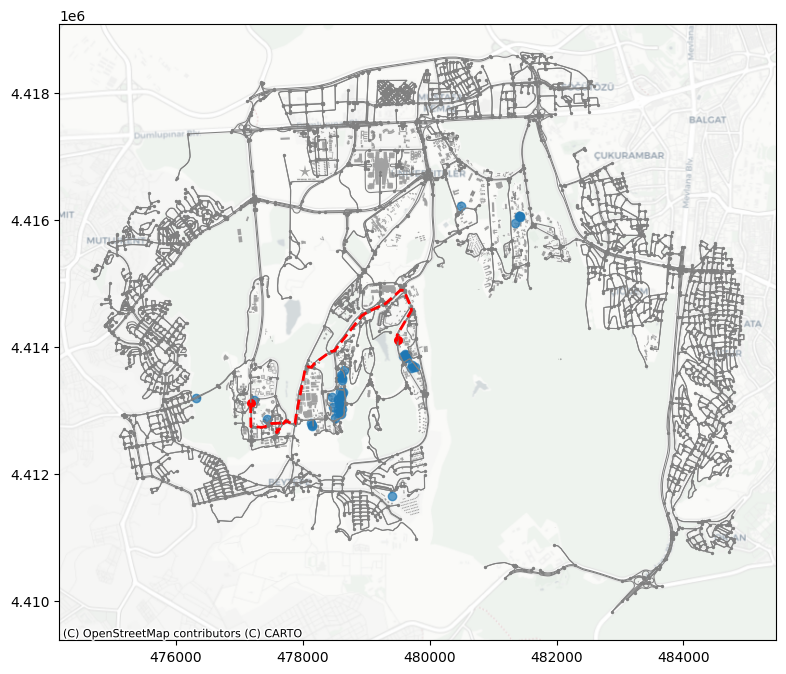

In [47]:
fig, ax = plt.subplots(figsize=(12,8))

# Plot edges and nodes
edges_proj.plot(ax=ax, linewidth=0.75, color='gray')
nodes_proj.plot(ax=ax, markersize=2, color='gray')

# Add buildings
ax = buildings_proj.plot(ax=ax, facecolor='gray', alpha=0.7)

# Add the route
ax = route_geom.plot(ax=ax, linewidth=2, linestyle='--', color='red')

# Add the origin and destination nodes of the route
ax = od_nodes.plot(ax=ax, markersize=30, color='red')

# Add basemap
ctx.add_basemap(ax, crs=buildings_proj.crs, source=ctx.providers.CartoDB.Positron)

Great everything seems to be in order! As you can see, now we have a full control of all the elements of our map and we can use all the aesthetic properties that matplotlib provides to modify how our map will look like. Now we are almost ready to save our data into disk.


## Prepare data for saving to file

The data contain certain data types (such as `list` or `boolean`) that should be converted into character strings prior to saving the data to file.Another option would be to drop invalid columns.

In [48]:
edges_proj.head()

osmid  oneway lanes  \
u           v           key                                                     
27046640    11033172719 0                            1158312502    True     5   
11033172719 11033172718 0                            1158312502    True     5   
            9953003882  0                            1188161426    True   NaN   
27046645    393950525   0    [1073556155, 1073556156, 34344989]    True     5   
393950525   2840120593  0                             234927859    True     2   

                              ref                 name     highway maxspeed  \
u           v           key                                                   
27046640    11033172719 0    D200      Dumlupınar Blv.       trunk       82   
11033172719 11033172718 0    D200      Dumlupınar Blv.       trunk       82   
            9953003882  0     NaN  İsmail Karakaya Cd.    tertiary      NaN   
27046645    393950525   0     NaN      Dumlupınar Blv.       trunk       82   
393950525   2840120593  0     NaN                  NaN  trunk_link      NaN   

                            reversed   length  \
u           v           key                     
27046640    11033172719 0      False  197.586   
11033172719 11033172718 0      False   63.760   
            9953003882  0      False   61.481   
27046645    393950525   0      False   74.870   
393950525   2840120593  0      False  207.891   

                                                                      geometry  \
u           v           key                                                      
27046640    11033172719 0    LINESTRING (481547.704 4417642.033, 481349.855...   
11033172719 11033172718 0    LINESTRING (481349.855 4417634.278, 481285.977...   
            9953003882  0    LINESTRING (481349.855 4417634.278, 481336.211...   
27046645    393950525   0    LINESTRING (481753.314 4417653.969, 481738.157...   
393950525   2840120593  0    LINESTRING (481678.404 4417649.887, 481660.457...   

                            bridge junction tunnel access width  
u           v           key                                      
27046640    11033172719 0      NaN      NaN    NaN    NaN   NaN  
11033172719 11033172718 0      NaN      NaN    NaN    NaN   NaN  
            9953003882  0      NaN      NaN    NaN    NaN   NaN  
27046645    393950525   0      yes      NaN    NaN    NaN   NaN  
393950525   2840120593  0      NaN      NaN    NaN    NaN   NaN

In [50]:
# Columns with invalid values
problematic_columns = [
    "osmid",
    "lanes",
    "name",
    "highway",
    "maxspeed",
    "reversed",
    "junction",
    "bridge",
    "tunnel",
    "access",
    "service",
]

# Convert selected columns to string format
edges[problematic_columns] = edges[problematic_columns].astype(str)


KeyError: "['service'] not in index"

In [51]:
route_geom

,geometry,osmids,length_m
0,"LINESTRING (477183.868 4413120.638, 477180.334...","[2190683018, 8533662516, 8533662515, 853367212...",5220.271674


In [52]:
route_geom["osmids"] = route_geom["osmids"].astype(str)


## Save the data:

In [53]:
# Save one layer after another
output_gpkg = "Universiteler_Mah.gpkg"

edges.to_file(output_gpkg, layer="streets")
route_geom.to_file(output_gpkg, layer="route")
nodes_proj.to_file(output_gpkg, layer="nodes")
buildings[['geometry', 'name', 'addr:street']].to_file(output_gpkg, layer="buildings")


ValueError: Invalid field type <class 'list'>

Great, now we have saved all the data that was used to produce the maps into a geopackage.